In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
from scipy.signal import butter, filtfilt, freqz
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from up_down import get_up_down
from utils import get_binary_stimuli, get_sample_interval, load, save, to_string

## Load Neural Data

In [9]:
# filename = '../../__data__/Mary-Anesthesia-20160809-01.mat'
filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01.mat'
# filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/MrJones-Anesthesia-20160121-01.mat'
# filename = r'/home/adameisen/common/datasets/anesthesia/mat/propofolWakeUp/Mary-Anesthesia-20170203-02.mat'
print("Loading data ...")
start = time.process_time()
# electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
electrode_info, lfp, lfp_schema, session_info, trial_inunit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'unitInfo'], verbose=False)
dt = lfp_schema['smpInterval'][0]
T = lfp.shape[0]

f = h5py.File(filename, 'r')
airPuff_binary, audio_binary = get_binary_stimuli(f)

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 83.10 seconds)


In [11]:
data_path = "../../__data__/VAR_poster_presentation/full_vlPFC"
# results[window]
# for window in [0.15, 0.25, 0.5, 1, 2.5, 5]:
#     stride = 500
#     results = load(os.path.join(data_path, f'results_window_{window}_stride_{stride}_PCA_dim_-1'))

# Plot Data

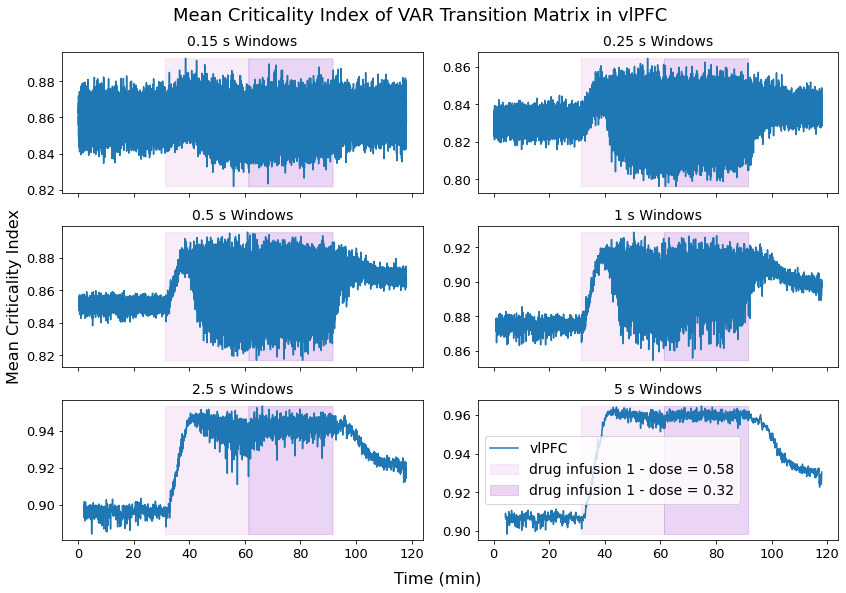

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharex=True)

for i, window in enumerate([0.15, 0.25, 0.5, 1, 2.5, 5]):
    ax = axs[int(i/2)][i % 2]
    stride = window
    results = load(os.path.join(data_path, f'results_window_{window}_stride_{stride}_PCA_dim_-1'))

    start_times = np.arange(results['eigs'].shape[0])*stride/60
    criticality_inds = results['eigs'].mean(axis=1)
    start_ind = 50
    start_times = start_times[start_ind:]
    criticality_inds = criticality_inds[start_ind:]
    ax.plot(start_times, criticality_inds, c='C0', label='vlPFC')
    
    ax.set_title(f"{window} s Windows", fontsize=14)
    if (i/2) == 1 and i % 2 == 0:
        ax.set_ylabel('Mean Criticality Index', fontsize=16)
        
    min_val = criticality_inds.min()
    max_val = criticality_inds.max()
    ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], stride)/60, 
                                min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
    ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride)/60, 
                            min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][1]}")
    ax.tick_params(labelsize=13)

ax.legend(fontsize=14)      
#     if i % 2 == 0:
#         min_val = criticality_inds.min()
#         max_val = criticality_inds.max()
#     else: # i % 2 == 1
#         if criticality_inds.min() < min_val:
#             min_val = criticality_inds.min()
#         if criticality_inds.max() > max_val:
#             max_val = criticality_inds.max()
    
#         for ax in [axs[int(i/2)][0], axs[int(i/2)][1]]:
    
#             ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], stride), 
#                                     min_val, max_val, color='C6', alpha=0.2, label='drug infusion 1')
#             ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride), 
#                                     min_val, max_val, color='C7', alpha=0.2, label='drug infusion 2')

        
fig.text(0.52, -0.02, 'Time (min)', ha='center', fontsize=16)
plt.suptitle("Mean Criticality Index of VAR Transition Matrix in vlPFC", fontsize=18)
plt.tight_layout()
plt.show()

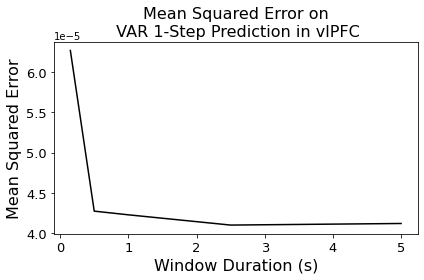

In [63]:
fig = plt.figure(figsize=(6, 4))

windows = [0.15, 0.5, 1, 2.5, 5]
# windows = [0.15, 0.5, 1]
mse = []

for i, window in enumerate(windows):
    stride = window
    results = load(os.path.join(data_path, f'results_window_{window}_stride_{stride}_PCA_dim_-1'))
    mse.append(results['mse'].mean())
    
start_times = np.arange(results['eigs'].shape[0])*window
plt.plot(windows, mse, c='k')
plt.xlabel('Window Duration (s)', fontsize=16)
plt.ylabel('Mean Squared Error', fontsize=16)
plt.title("Mean Squared Error on\n VAR 1-Step Prediction in vlPFC", fontsize=16)
ax=plt.gca()
ax.tick_params(labelsize=13)

plt.tight_layout()
plt.show()

## Sampled Wakeful Traces

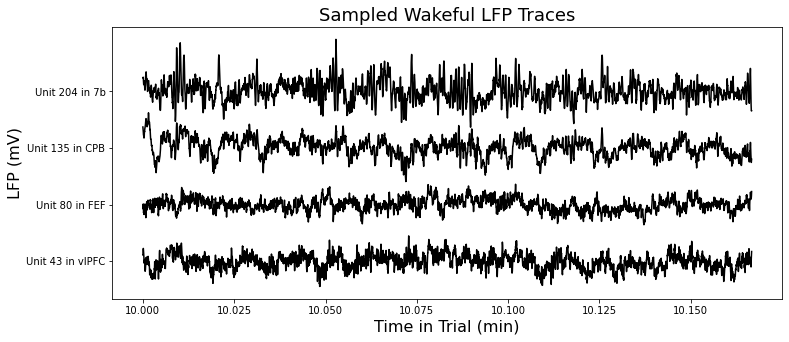

In [13]:
plt.figure(figsize=(12, 5))
start = 600
end = 610
t = np.arange(start, end, dt)/60
offset = 0.25
indices = [43, 80, 135, 204]
for i, index in enumerate(indices):
    plt.plot(t, lfp[int(start/dt):int(end/dt), index] + i*offset, c='black')
plt.yticks([i*offset for i in range(len(indices))], [f"Unit {index} in {electrode_info['area'][index]}" for index in indices])
plt.xlabel('Time in Trial (min)', fontsize=16)
plt.ylabel('LFP (mV)', fontsize=16)
plt.title("Sampled Wakeful LFP Traces", fontsize=18)
plt.show()

## Sampled Anesthetic Traces

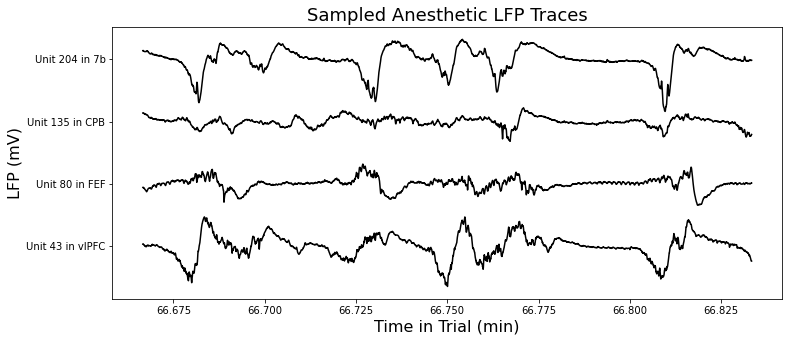

In [14]:
plt.figure(figsize=(12, 5))
start = 4000
end = 4010
t = np.arange(start, end, dt)/60
offset = 1
indices = [43, 80, 135, 204]
for i, index in enumerate(indices):
    plt.plot(t, lfp[int(start/dt):int(end/dt), index] + i*offset, c='black')
plt.yticks([i*offset for i in range(len(indices))], [f"Unit {index} in {electrode_info['area'][index]}" for index in indices])
plt.xlabel('Time in Trial (min)', fontsize=16)
plt.ylabel('LFP (mV)', fontsize=16)
plt.title("Sampled Anesthetic LFP Traces", fontsize=18)
plt.show()

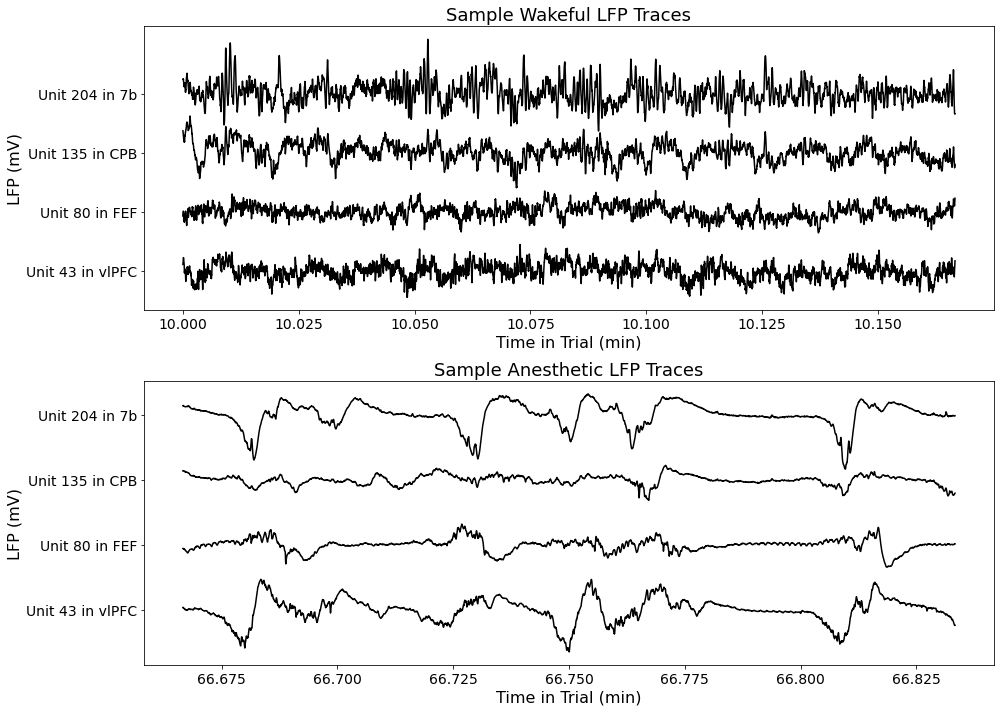

In [21]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
start = 600
end = 610
t = np.arange(start, end, dt)/60
offset = 0.25
indices = [43, 80, 135, 204]
for i, index in enumerate(indices):
    plt.plot(t, lfp[int(start/dt):int(end/dt), index] + i*offset, c='black')
plt.yticks([i*offset for i in range(len(indices))], [f"Unit {index} in {electrode_info['area'][index]}" for index in indices])
plt.xlabel('Time in Trial (min)', fontsize=16)
plt.ylabel('LFP (mV)', fontsize=16)
plt.title("Sample Wakeful LFP Traces", fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)

plt.subplot(2, 1, 2)
start = 4000
end = 4010
t = np.arange(start, end, dt)/60
offset = 1
indices = [43, 80, 135, 204]
for i, index in enumerate(indices):
    plt.plot(t, lfp[int(start/dt):int(end/dt), index] + i*offset, c='black')
plt.yticks([i*offset for i in range(len(indices))], [f"Unit {index} in {electrode_info['area'][index]}" for index in indices])
plt.xlabel('Time in Trial (min)', fontsize=16)
plt.ylabel('LFP (mV)', fontsize=16)
plt.title("Sample Anesthetic LFP Traces", fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

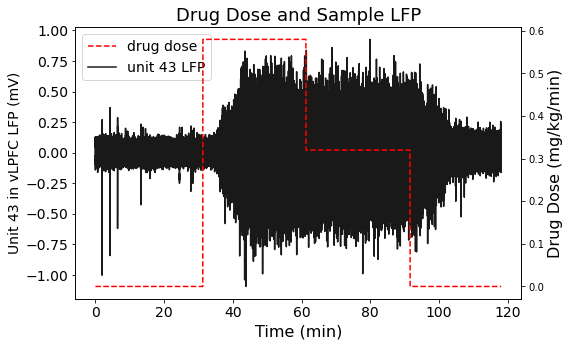

In [58]:
plt.figure(figsize=(8, 5))
drug_dose = np.zeros(lfp.shape[0])
drug_dose[int(session_info['drugStart'][0]/dt):int(session_info['drugEnd'][0]/dt)] = session_info['drugDose'][0]
drug_dose[int(session_info['drugStart'][1]/dt):int(session_info['drugEnd'][1]/dt)] = session_info['drugDose'][1]
t = np.arange(lfp.shape[0])/1000/60

# make a plot with different y-axis using second axis object
ln2 = plt.plot(t, lfp[:,43], c='k', alpha = 0.9, label='unit 43 LFP', zorder=0)
ax = plt.gca()
ax.tick_params(labelsize=14)
ax.set_ylabel("Unit 43 in vLPFC LFP (mV)",fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('Time (min)', fontsize=16)


ax2=ax.twinx()
ln1 = ax2.plot(t, drug_dose, c='red', linestyle='--', label='drug dose', zorder=10)
ax2.set_ylabel('Drug Dose (mg/kg/min)', fontsize=16)




lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, fontsize=14)

plt.title("Drug Dose and Sample LFP", fontsize=18)
fig.set_zorder(ax2.get_zorder()+1)
fig.patch.set_visible(False)
# plt.legend(fontsize=14)
plt.show()

## Multi-Region

In [60]:
results['eigs']

array([[0.95207689, 0.95207689, 0.8494805 , ..., 0.94083578, 0.94192212,
        0.94634891],
       [0.94610109, 0.94610109, 0.87274356, ..., 0.90512158, 0.92534734,
        0.91673418],
       [0.95108459, 0.95108459, 0.90612255, ..., 0.91764326, 0.91233731,
        0.89215372],
       ...,
       [0.96646592, 0.96646592, 0.93768884, ..., 0.94142844, 0.94142844,
        0.92717066],
       [0.97745415, 0.97745415, 0.96188993, ..., 0.93406611, 0.91589359,
        0.92165242],
       [0.97180395, 0.97180395, 0.95795205, ..., 0.94603129, 0.94150509,
        0.94150509]])

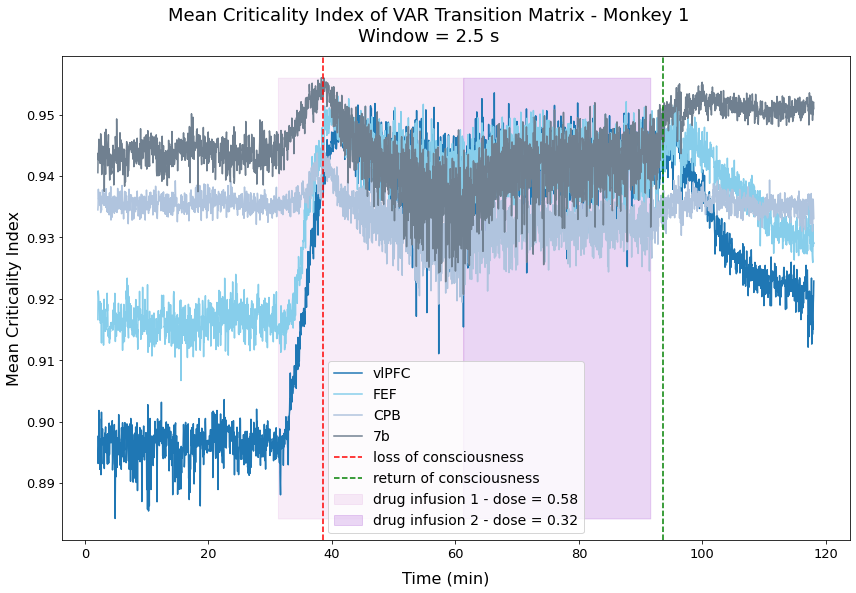

In [11]:
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()

window = 2.5
stride = window
data_path = "../../__data__/VAR_poster_presentation/multi_region"
results = load(os.path.join(data_path, f'results_window_{window}_stride_{stride}_PCA_dim_-1'))

min_val = np.Inf
max_val = -np.Inf
for area, c in [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray')]:
# for area, c in [('vlPFC', 'C0')]:
    start_times = np.arange(results[area]['eigs'].shape[0])*stride/60
    criticality_inds = results[area]['eigs'].mean(axis=1)
    start_ind = 50
    start_times = start_times[start_ind:]
    criticality_inds = criticality_inds[start_ind:]
    ax.plot(start_times, criticality_inds, label=area, c=c)
    
    if criticality_inds.min() < min_val:
        min_val = criticality_inds.min()
    if criticality_inds.max() > max_val:
        max_val = criticality_inds.max()

# min_val = criticality_inds.min()
# max_val = criticality_inds.max()
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], stride)/60, 
                                min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride)/60, 
                        min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 2 - dose = {session_info['drugDose'][1]}")

plt.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
plt.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")
ax.legend(fontsize=14)        
fig.text(0.52, -0.02, 'Time (min)', ha='center', fontsize=16)
ax.set_ylabel('Mean Criticality Index', fontsize=16)
ax.tick_params(labelsize=13)
plt.suptitle("Mean Criticality Index of VAR Transition Matrix - Monkey 1\nWindow = 2.5 s", fontsize=18)
plt.tight_layout()
plt.show()

In [2]:
trial_info

NameError: name 'trial_info' is not defined

In [8]:
# dose in mg/kg/min

$$\Large x_t = Ax_{t-1} + \eta_t$$

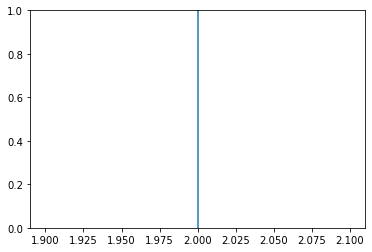

In [73]:
plt.axvline(2)